## Stage 2: Dyad prediction 
### Using outflow predictions as covariate

In [1]:
# Imports
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import os
import model_helpers
from multiprocesspandas import applyparallel
import matplotlib.pyplot as plt


from category_encoders import OneHotEncoder
from category_encoders import BinaryEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn import set_config
set_config(display="diagram")
from sklearn.compose import ColumnTransformer

from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor



In [2]:
path = '../../data/clean/'
SEED = 12
unhcr = pd.read_csv(path + 'unhcr.csv', engine='pyarrow')


In [3]:
unhcr['year'] = pd.to_datetime(unhcr['year'], format='%Y')
unhcr["year"] = unhcr["year"].dt.year

unhcr = unhcr.dropna(subset=["newarrival"])

In [4]:
id_var = unhcr.Id.unique().tolist()

In [5]:
unhcr["y_naive"] = unhcr.groupby(['Id']).newarrival.shift(1)

In [6]:
# Create train/test split
test_time_start = 2019
test_time_end = 2021
train = unhcr.loc[unhcr.year < test_time_start]
test = unhcr.loc[(unhcr.year >= test_time_start) & (unhcr.year <= test_time_end)]

In [7]:
# y_naive = model_helpers.apply_naive_prediction(train, test, target="newarrival", 
#                                               country_var='Id', lst_countries=id_var
#                                               )



In [8]:
mse_naive = mean_squared_error(y_pred=test["y_naive"], y_true=test["newarrival"], squared=False)
print(mse_naive)

2629.108510290297


In [9]:
data = {
    'Id': test.Id,
    'year': test.year,
    'y_pred': test.y_naive,
    'y_test': test.newarrival
}
predictions = pd.DataFrame(data)
predictions

,Id,year,y_pred,y_test
19,AFGALB,2019,36.0,3.0
20,AFGALB,2020,3.0,0.0
21,AFGALB,2021,0.0,4.0
44,AFGDZA,2019,0.0,0.0
45,AFGDZA,2020,0.0,0.0
...,...,...,...,...
955470,ZWEYEM,2020,0.0,0.0
955471,ZWEYEM,2021,0.0,0.0
955494,ZWEZMB,2019,2.0,0.0
955495,ZWEZMB,2020,0.0,1.0


In [10]:
mse_naive_dict = {}

for year in range(2019, 2022):
    data_year = predictions.loc[predictions.year == year]
    mse = mean_squared_error(y_pred=data_year.y_pred, y_true=data_year.y_test, squared=False)
    mse_naive_dict[year] = mse
    print("MSE Naive RW " + str(year) + ": " + str(mse_naive_dict[year]))

MSE Naive RW 2019: 3182.7968366122777
MSE Naive RW 2020: 3016.792178650462
MSE Naive RW 2021: 1226.94903085942


### Model 1: Relying only on GTrends to predict dyad flows

This version of the model doesn't include refugee outflow predictions yet. It only relies on one Google Trend: visa + country (interactions for every country).

We first do some feature engineering on the trend (spike smoothing, multiplied by population and internet penetration levels, considering rolling sums of recent months, avg and max to aggregate from months to years -- same as outflow preprocessing). 

For now, we are just testing the validity of GTrends as predictor.

#### Importing and preprocessing

In [11]:
visatrend = pd.read_csv("../trends/trends_downloads/interactions_full/interactions visa.csv")

In [12]:
# Extract country name and convert to ISO-3 code
visatrend["name"] = visatrend['keyword_en'].str.split(' ', expand=True)[1]
names = visatrend["name"].unique()
df = pd.DataFrame(names, columns=["name"])
df = df[df["name"].isnull()==False]
df["iso_d"] = df["name"].apply(model_helpers.name_to_iso3)
visatrend = pd.merge(visatrend, df, on="name", how="left")

iso_o_list = visatrend.region.unique()
df = pd.DataFrame(iso_o_list, columns=["region"])
df = df[df["region"].isnull()==False]
df["iso_o"] = df["region"].apply(model_helpers.convert_iso2_to_iso3)
visatrend = pd.merge(visatrend, df, on="region", how="left")


In [13]:
visatrend = visatrend.drop(columns=["country", "language", "name", "region", "keyword_en", "keyword"])
visatrend_av = visatrend.groupby(['iso_o', 'iso_d', 'date']).mean().reset_index()
visatrend_max = visatrend.groupby(['iso_o', 'iso_d', 'date']).max().reset_index()
visatrend_av = visatrend_av.rename(columns={"trends_index":"visa_avg"})
visatrend_max = visatrend_max.rename(columns={"trends_index":"visa_max"})

In [14]:
visa_final = pd.merge(visatrend_av, visatrend_max, on=["iso_o", "iso_d", "date"], how="left")
print(visa_final.shape)
visa_final.head()


(710424, 5)


,iso_o,iso_d,date,visa_avg,visa_max
0,AFG,AUS,2005-01-01,0.0,0
1,AFG,AUS,2005-02-01,0.0,0
2,AFG,AUS,2005-03-01,0.0,0
3,AFG,AUS,2005-04-01,0.0,0
4,AFG,AUS,2005-05-01,0.0,0


In [15]:

# visa_final.to_csv("../../data/clean/visa_full_gtrend.csv", index=False)

Using spike smoothing function:

In [16]:
visa_smoothed = visa_final.apply(model_helpers.smooth_spikes_2)
visa_smoothed["date"] = pd.to_datetime(visa_smoothed["date"])

In [17]:
visa_smoothed['year'] = visa_smoothed['date'].dt.year
visa_smoothed['month'] = visa_smoothed['date'].dt.month
visa_smoothed = visa_smoothed.drop(columns=["date"])


Generating rolling sums for recent months:

In [18]:
final_keywords_list = visa_smoothed.columns[~visa_smoothed.columns.isin(['year', 'month', 'iso_o', 'iso_d'])]

In [19]:
window_sizes = [2, 4, 7] # rolling sums for the last (1), 3 and 6 months
group_cols = ['iso_o', 'iso_d', 'year']
value_cols = final_keywords_list

panel_trends = model_helpers.generate_rolling_sum_variables(visa_smoothed, group_cols, value_cols, window_sizes, date_col='month')

panel_trends = panel_trends[panel_trends["month"]==12]


panel_trends

,iso_o,iso_d,visa_avg,visa_max,year,month,rolling_sum_past_1_visa_avg,rolling_sum_past_3_visa_avg,rolling_sum_past_6_visa_avg,rolling_sum_past_1_visa_max,rolling_sum_past_3_visa_max,rolling_sum_past_6_visa_max
11,AFG,AUS,0.0,0.0,2005,12,0.0,0.0,0.0,0.0,0.0,0.0
23,AFG,AUS,0.0,0.0,2006,12,82.0,82.0,82.0,82.0,82.0,82.0
35,AFG,AUS,36.0,36.0,2007,12,76.0,76.0,76.0,76.0,76.0,76.0
47,AFG,AUS,0.0,0.0,2008,12,0.0,94.0,94.0,0.0,94.0,94.0
59,AFG,AUS,0.0,0.0,2009,12,0.0,69.0,100.0,0.0,69.0,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...
710375,ZWE,ZWE,6.0,6.0,2018,12,14.0,27.0,46.0,14.0,27.0,46.0
710387,ZWE,ZWE,8.0,8.0,2019,12,14.0,29.0,52.0,14.0,29.0,52.0
710399,ZWE,ZWE,4.0,4.0,2020,12,9.0,17.0,27.0,9.0,17.0,27.0
710411,ZWE,ZWE,5.0,5.0,2021,12,10.0,23.0,41.0,10.0,23.0,41.0


In [20]:
trends_final = panel_trends.fillna(0)

In [21]:
trends_final = trends_final.drop(columns="rolling_sum_past_1_visa_max")

Population and internet penetration interactions:

In [22]:
internet = pd.read_csv("../../data/raw/Internet penetration_WB.csv").drop(columns=["Country Name", "Indicator Name", "Indicator Code"])

value_vars = internet.columns.difference(['Country Code']).tolist()

internet_long = pd.melt(internet, id_vars=['Country Code'], value_vars=value_vars,
                  var_name='year', value_name='internet')
internet_long["year"] = pd.to_datetime(internet_long["year"])
internet_long['year'] = internet_long['year'].dt.year
internet_long = internet_long[internet_long["year"]>=2000]

# Because this has only weighting purpose, I'll fill nans with 1 in the version to multiply
internet_long = internet_long.copy().fillna(1)
internet_long = internet_long.rename(columns={"Country Code":"iso_o"})

In [23]:
data_outflows_2005 = unhcr[unhcr["year"]>=2005]
data_outflows_2005 = data_outflows_2005[["iso_o", "iso_d", "year", "newarrival", "pop_o"]]
trends_merged = pd.merge(data_outflows_2005, trends_final, on=["iso_o", "iso_d", "year"], how="left")

trends_merged = pd.merge(trends_merged, internet_long, on=["iso_o", "year"], how='left')

trends_merged = trends_merged.drop(columns="month")


In [24]:
trends_merged.shape

(649701, 13)

In [25]:
float_columns = trends_merged.select_dtypes(include=['float64']).columns
trends_merged = trends_merged.fillna(0)
trends_merged[float_columns] = trends_merged[float_columns].astype(int)


# Create a list of variables to weight
variables_to_multiply = [col for col in trends_merged.columns if col not in ['iso_o', 'iso_d', 'year', 'pop_o', 'internet', 'newarrival']]

# Multiply the variables by 'pop_o' and 'internet'
trends_merged[variables_to_multiply] = trends_merged[variables_to_multiply].multiply(trends_merged['pop_o'], axis=0).multiply(trends_merged['internet'], axis=0)

# Drop non-multiplied variables, 'pop_o', and 'internet'
# columns_to_drop = ['internet', 'pop_o]
# trends_merged.drop(columns=columns_to_drop, inplace=True)

trends_merged.shape
trends_merged.head()


,iso_o,iso_d,year,newarrival,pop_o,visa_avg,visa_max,rolling_sum_past_1_visa_avg,rolling_sum_past_3_visa_avg,rolling_sum_past_6_visa_avg,rolling_sum_past_3_visa_max,rolling_sum_past_6_visa_max,internet
0,AFG,ALB,2005,0,20,0,0,0,0,0,0,0,1
1,AFG,ALB,2006,0,21,0,0,0,0,0,0,0,2
2,AFG,ALB,2007,0,22,0,0,0,0,0,0,0,1
3,AFG,ALB,2008,0,22,0,0,0,0,0,0,0,1
4,AFG,ALB,2009,0,23,0,0,0,0,0,0,0,3


In [26]:
trends_merged["target"] = trends_merged.groupby(['iso_o', 'iso_d']).newarrival.shift(-1)
trends_merged = trends_merged.drop(columns=["newarrival"])
trends_merged = trends_merged.dropna()

### Testing a simple model: 

Visa trends + dyad fixed effects (+ controls: internet + pop_o)

In [27]:
test_time_start = 2018
test_time_end = 2020

In [28]:
binary_cols = ['iso_o', 'iso_d']

rf_pipe = model_helpers.pipeline_tree(model=RandomForestRegressor(random_state=SEED, n_jobs=-1), 
                                      df=trends_merged,
                                      binary_cols=binary_cols)

In [31]:
X_train, X_test, y_train, y_test = model_helpers.train_test_split(trends_merged, 'target', test_time_start, test_time_end, 'year')

In [32]:
rf_pipe.fit(X_train, y_train)

y_pred = rf_pipe.predict(X_test)
y_pred = np.clip(y_pred, 0, None)
mse_trends_weighted = mean_squared_error(y_test, y_pred, squared=False)

print("RMSE outflows - GTrends only (weighted): " + str(mse_trends_weighted))
print("Relative RMSE to Naive predictions: " + str(mse_trends_weighted/mse_naive))

RMSE outflows - GTrends only (weighted): 2671.589509625256
Relative RMSE to Naive predictions: 1.0161579482812098


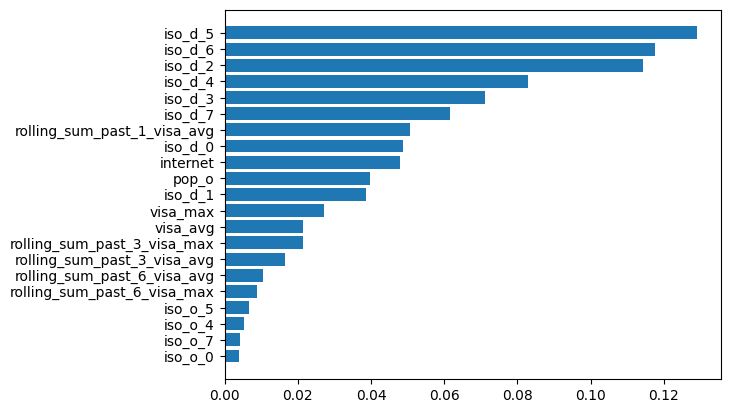

In [33]:
numerical_cols = list(set(trends_merged.columns) - set(binary_cols  + ['year', 'target']))

importances = rf_pipe.named_steps['rf'].feature_importances_

# Get column names from ColumnTransformer object
column_names = list(rf_pipe.named_steps['preprocessing'].transformers_[0][1].get_feature_names_out()) + numerical_cols


# Map feature importances to column names
feature_importances = dict(zip(column_names, importances))

indexes = model_helpers.feature_imp_more(feature_importances)

Countries fixed effects are important, also the controls internet and population, but the visa features are working

With rolling windows and log transformation:

In [34]:
X_train_list, X_test_list, y_train_list, y_test_list = model_helpers.train_test_split_rw(trends_merged, 'target', test_time_start, test_time_end, 'year')

In [35]:
mse_visa_log_dict = {}
predictions_list = []
feature_importances_dict={}
# Iterate over the test sets for each year
for year, X_train, X_test, y_train, y_test in zip(range(test_time_start, test_time_end + 1), X_train_list, X_test_list, y_train_list, y_test_list):


    epsilon = 1e-8
    y_train_log = np.log(y_train + epsilon)

    rf_pipe.fit(X_train, y_train_log)

    # Predict on test set and transform back to original scale
    y_pred_log = rf_pipe.predict(X_test)
    y_pred = np.exp(y_pred_log) 

    # Get feature importances from the Random Forest model
    feature_importances = rf_pipe.named_steps['rf'].feature_importances_
    column_names = list(rf_pipe.named_steps['preprocessing'].transformers_[0][1].get_feature_names_out()) + numerical_cols
    # Store feature importances in the dictionary
    feature_importances_dict[year+1] = dict(zip(column_names, feature_importances))
    
    mse_visa_log_year = mean_squared_error(y_test, y_pred, squared=False)

    mse_visa_log_dict[year+1] = mse_visa_log_year

    print("*********")
    print("Year: " + str(year+1))
    print("X_train uses data until: " + str(X_train.year.max()))
    print("RMSE using just gtrends: " + str(mse_visa_log_year))
    print("Relative RMSE to Naive predictions: " + str(mse_visa_log_year / mse_naive_dict[year+1]))

    # Store predicted values in DataFrame
    predictions_list.append(pd.DataFrame({"year": [year+1] * len(X_test),
                                            "iso_o": X_test["iso_o"].values,
                                            "y_pred_visa_log_rw": y_pred}))

    # Concatenate DataFrames from the list
    predictions_df_visa_log = pd.concat(predictions_list, ignore_index=True)

*********
Year: 2019
X_train uses data until: 2017
RMSE using just gtrends: 3761.6832927169135
Relative RMSE to Naive predictions: 1.1818798012633422
*********
Year: 2020
X_train uses data until: 2018
RMSE using just gtrends: 1478.7330489813812
Relative RMSE to Naive predictions: 0.4901673570510517
*********
Year: 2021
X_train uses data until: 2019
RMSE using just gtrends: 1912.6986448012394
Relative RMSE to Naive predictions: 1.5589063577168192


In [36]:
# recuperating y_test for the comparison
X_train, X_test, y_train, y_test = model_helpers.train_test_split(trends_merged, 'target', test_time_start, test_time_end, 'year')

In [37]:
print(mean_squared_error(y_true=y_test, y_pred=predictions_df_visa_log.y_pred_visa_log_rw, squared=False))
print(mean_squared_error(y_true=y_test, y_pred=predictions_df_visa_log.y_pred_visa_log_rw, squared=False)/mse_naive)

2602.5313507459227
0.989891189564694


In [38]:

def feature_years(feature_importances_dict):
        # List of years
    years = [2019, 2020, 2021]

    # Create a 2x2 grid of subplots
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    # Flatten the axes to iterate over them easily
    axes = axes.flatten()

    # Iterate over the years and plot the bar plots in the grid
    for i, year in enumerate(years):
        ax = axes[i]
        ax.set_title(f"Year {year}")  # Set title for each subplot with the corresponding year
        
        
        # Sort the feature importances in descending order and get the top 20 features
        top_features = sorted(feature_importances_dict[year].items(), key=lambda x: x[1], reverse=True)[:20]
        top_features = list(reversed(top_features))
        top_features_names, top_features_importances = zip(*top_features)
        
        # Plot the bar chart
        ax.barh(range(len(top_features_names)), top_features_importances, align='center')
        ax.set_yticks(range(len(top_features_names)))
        ax.set_yticklabels(top_features_names)
        ax.set_xlabel('Importance')

    # Adjust the layout and spacing
    plt.tight_layout()

    # Show the plots
    plt.show()

Saving the visa preprocessed features:

In [35]:
# visa_to_save = trends_merged.drop(columns='target')
# visa_to_save.to_csv(path + "visa_interacted_preprocessed.csv", index=False)

## Model 2: GTrends (visa + country) + refugee outflow predictions as covariate

Adding refugee flow prediction as covariate. We train the model with the real refugee outflow data, and test it with our predicted values.

Note: we are using here Random Forest Regressor. This works better for the simpler models using mostly gtrends. When we get to the part of adding UNHCR covariates, we start using Gradient Boosting, which performs better in that case.

In [39]:
data_outflows_test = pd.read_csv("../../best predictions/outflows_best_rw (3-7).csv")
data_outflows_test

,year,iso_o,y_naive,y_pred_conflict_log_rw
0,2019,ABW,0.0,0.000002
1,2020,ABW,1.0,0.000761
2,2021,ABW,0.0,0.000472
3,2019,AFG,116209.0,59098.926909
4,2020,AFG,130489.0,68889.220231
...,...,...,...,...
583,2020,ZMB,142.0,153.106512
584,2021,ZMB,86.0,91.292241
585,2019,ZWE,1908.0,2104.563826
586,2020,ZWE,3371.0,4710.330135


In [40]:
data_outflows_test = pd.read_csv("../../best predictions/outflows_best_rw (3-7).csv")
data_outflows_test = data_outflows_test[["year", "iso_o", "y_pred_conflict_log_rw"]]
data_outflows_test = data_outflows_test.rename(columns={"y_pred_conflict_log_rw":"ref_outflow_pred"})


df_full = pd.read_csv(path + 'unhcr.csv', engine='pyarrow').drop_duplicates(subset=['Id','year'])[['iso_o', 'iso_d','Id','year', 'newarrival']]# 'pop_o', 'CPI_o', 'GDP_PP_o', 'GDP_PPP_o',
        #'island_o', 'area_o', 'landlocked_o', 'PR_o', 'CL_o',
        #'typeOfViolence_o', 'best_est_o', 'Nyear_conflict_o', 'Nyear_log_o',
        #'dead_log_o', 'Nyear_conf_o', 'dead_o', 'newarrival']]

df_full['year'] = pd.to_datetime(df_full['year'], format='%Y')
df_full["year"] = df_full["year"].dt.year
df_full = df_full.sort_values(by=['iso_o', 'iso_d','year'], ascending=[True, True, True])
df_full = df_full.reset_index(drop=True)

data_outflows = df_full.groupby(['iso_o', 'year']).newarrival.sum()
data_outflows = data_outflows.reset_index()
data_outflows = data_outflows.rename(columns={"newarrival":"ref_outflow"})

# Merge the two dataframes based on the common id variable
df_merged = df_full.merge(data_outflows, left_on=['iso_o','year'], right_on=['iso_o','year'])
df_merged = df_merged.sort_values(by=['iso_o', 'iso_d','year'], ascending=[True, True, True])
df_merged = df_merged.reset_index(drop=True)
df_merged = df_merged.rename(columns={'ref_outflow': 'ref_outflow_last_year'})




In [41]:
df_merged = pd.merge(df_merged, data_outflows_test, on=["iso_o", "year"], how='outer')

In [42]:
df_merged = df_merged.loc[df_merged["year"] <= 2021]    
df_merged['ref_outflow_pred'].fillna(df_merged['ref_outflow_last_year'], inplace=True)
df_merged

,iso_o,iso_d,Id,year,newarrival,ref_outflow_last_year,ref_outflow_pred
0,ABW,AFG,ABWAFG,2000,0.0,0.0,0.000000
1,ABW,AGO,ABWAGO,2000,0.0,0.0,0.000000
2,ABW,ALB,ABWALB,2000,0.0,0.0,0.000000
3,ABW,AND,ABWAND,2000,0.0,0.0,0.000000
4,ABW,ARE,ABWARE,2000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...
954910,ZWE,WBG,ZWEWBG,2021,0.0,640.0,1733.466227
954911,ZWE,WSM,ZWEWSM,2021,0.0,640.0,1733.466227
954912,ZWE,YEM,ZWEYEM,2021,0.0,640.0,1733.466227
954913,ZWE,ZAF,ZWEZAF,2021,0.0,640.0,1733.466227


In [43]:
df_merged = df_merged[["iso_o", "year", "ref_outflow_last_year", "ref_outflow_pred"]].drop_duplicates()
df_merged.shape

(4312, 4)

In [44]:
trends_merged_out = pd.merge(trends_merged, df_merged, on=["year", "iso_o"], how="left")

In [45]:
# ohe = OneHotEncoder()
be = BinaryEncoder() # doing be on everything yields better results
cont_scaler = RobustScaler()

# binary_cols = ['iso_o']
# ohe_cols = ['iso_o_continent','typeOfViolence_o']
binary_cols = ['iso_o', 'iso_d']

# numerical_cols = list(set(unhcr.columns) - set(binary_cols + ohe_cols + ['year', 'ref_outflow']))
numerical_cols = list(set(trends_merged_out.columns) - set(binary_cols  + ['year', 'target']))

transform_cols = ColumnTransformer(
    [
        ('cat1', be, binary_cols),
   #     ('cat2', ohe, ohe_cols),
        ('num', cont_scaler, numerical_cols)
    ],
    remainder='passthrough'
)

gb_pipe = Pipeline([('preprocessing', transform_cols),
                    ('gb', RandomForestRegressor(random_state=SEED, n_jobs=-1))])

In [118]:
X_train, X_test, y_train, y_test = model_helpers.train_test_split(trends_merged_out, 'target', test_time_start, test_time_end, 'year')


In [119]:
gb_pipe = model_helpers.pipeline_tree(model=GradientBoostingRegressor(random_state=SEED),
                                                                  df=trends_merged_out,
                                                                  binary_cols=binary_cols)
gb_pipe.fit(X_train, y_train)

y_pred = gb_pipe.predict(X_test)
y_pred = np.clip(y_pred, 0, None)
mse_aug = mean_squared_error(y_test, y_pred, squared=False)

print("RMSE: " + str(mse_aug))
print("Relative RMSE to Naive predictions: " + str(mse_aug/mse_naive))

RMSE: 3220.697403187523
Relative RMSE to Naive predictions: 1.2250150157674187


In [46]:
X_train_list, X_test_list, y_train_list, y_test_list = model_helpers.train_test_split_rw(trends_merged_out, 'target', test_time_start, test_time_end, 'year')

In [47]:
mse_visa_outflows_log_dict = {}
predictions_list = []
feature_importances_dict = {}
# Iterate over the test sets for each year
for year, X_train, X_test, y_train, y_test in zip(range(test_time_start, test_time_end + 1), X_train_list, X_test_list, y_train_list, y_test_list):


    epsilon = 1e-8
    y_train_log = np.log(y_train + epsilon)

    gb_pipe.fit(X_train, y_train_log)

    # Predict on test set and transform back to original scale
    y_pred_log = gb_pipe.predict(X_test)
    y_pred = np.exp(y_pred_log) 

    # Get feature importances from the Random Forest model
    feature_importances = gb_pipe.named_steps['gb'].feature_importances_
    column_names = list(gb_pipe.named_steps['preprocessing'].transformers_[0][1].get_feature_names_out()) + numerical_cols
    # Store feature importances in the dictionary
    feature_importances_dict[year+1] = dict(zip(column_names, feature_importances))

    
    mse_visa_outflows_log_year = mean_squared_error(y_test, y_pred, squared=False)

    mse_visa_outflows_log_dict[year + 1] = mse_visa_outflows_log_year

    print("*********")
    print("Year: " + str(year +1))
    print("X_train uses data until: " + str(X_train.year.max()))
    print("RMSE gtrends (visa) + ref_outflows_pred: " + str(mse_visa_outflows_log_year))
    print("Relative RMSE to Naive predictions: " + str(mse_visa_outflows_log_year / mse_naive_dict[year+1]))


    # Store predicted values in DataFrame
    predictions_list.append(pd.DataFrame({"year": [year + 1] * len(X_test),
                                            "iso_o": X_test["iso_o"].values,
                                            "y_pred_visa_outflows_log_rw": y_pred}))

    # Concatenate DataFrames from the list
    predictions_df_visa_outflows_log = pd.concat(predictions_list, ignore_index=True)

*********
Year: 2019
X_train uses data until: 2017
RMSE gtrends (visa) + ref_outflows_pred: 3760.4118011043656
Relative RMSE to Naive predictions: 1.181480312487332
*********
Year: 2020
X_train uses data until: 2018
RMSE gtrends (visa) + ref_outflows_pred: 1476.869853340387
Relative RMSE to Naive predictions: 0.48954974883323016
*********
Year: 2021
X_train uses data until: 2019
RMSE gtrends (visa) + ref_outflows_pred: 1907.3264508745772
Relative RMSE to Naive predictions: 1.5545278596769296


In [49]:
# recuperating y_test for the comparison
X_train, X_test, y_train, y_test = model_helpers.train_test_split(trends_merged_out, 'target', test_time_start, test_time_end, 'year')

In [50]:
print(mean_squared_error(y_true=y_test, y_pred=predictions_df_visa_outflows_log.y_pred_visa_outflows_log_rw, squared=False))
print(mean_squared_error(y_true=y_test, y_pred=predictions_df_visa_outflows_log.y_pred_visa_outflows_log_rw, squared=False)/mse_naive)

2606.4057776835702
0.9913648552283526


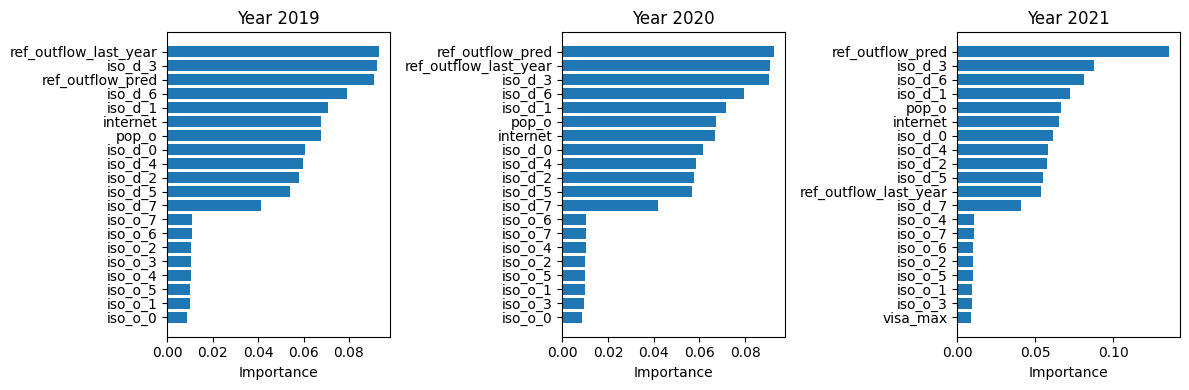

In [51]:
feature_years(feature_importances_dict=feature_importances_dict)

With refugee flow predictions + gtrends data, we can achieve a lower RMSE than the naive model on average, although the prediction is much better for some years. 


We can add some lags and rolling sums for the ref_outflow data to see if it helps:

### Model 3: Gtrends (visa + country, neighboring cities and neighboring countries) + refugee outflow predictions

I am importing a dataframe that contains UNHCR covariates and Gtrends for neighboring cities and countries already preprocessed. This was generated in another notebook - because the dataset is too heavy (and has UNHCR data) is not currently on github. You can access it here: https://drive.google.com/file/d/1aEcnhXgogkk1YM1zSAciqOOATYPSIufG/view?usp=sharing 

In [52]:
dyad_covs = pd.read_csv(path + "dyad_df (partial).csv")
dyad_covs = dyad_covs.drop(columns=["Unnamed: 0"])
dyad_covs['year'] = pd.to_datetime(dyad_covs['year'], format='%Y')
dyad_covs["year"] = dyad_covs["year"].dt.year
dyad_covs = dyad_covs.loc[(dyad_covs["year"] > 2004) & (dyad_covs["year"]<= 2021)]
dyad_covs = dyad_covs.drop(columns=['Country_o', 'Country_d', 'newarrival', 'internet', 'pop_o'])

The UNHCR columns labeled `_o` have already been used in the refugee outflow predictions. Here, we are dropping them, along with other features that might not add valuable information (e.g. lags/rolling sums for conflict-related variables in the destination country - if we keep 1 lag, we'll probably be fine and we don't increase dimensionality that much).

In [53]:
dyad_covs = dyad_covs.drop(columns=[ 'CPI_o', 'GDP_PP_o', 'GDP_PPP_o', 'island_o', 'area_o',
       'landlocked_o', 'PR_o', 'CL_o', 'typeOfViolence_o', 'best_est_o',
       'Nyear_conflict_o', 'Nyear_log_o', 'dead_log_o', 'Nyear_conf_o',
       'dead_o', 'Shift_2_GDP_PP_d', 'Shift_2_GDP_PPP_d', 'Shift_2_PR_d', 'Shift_2_CL_d',
       'Shift_2_Nyear_conflict_d', 'Shift_2_Nyear_log_d',
       'Shift_2_typeOfViolence_d', 'Shift_2_Nyear_conf_d', 'Shift_1_typeOfViolence_d',
       'Shift_3_dead_d',
       'Shift_3_best_est_d', 'Shift_3_dead_log_d',
       'rolling_sum_past_3_best_est_d'])

In [54]:
dyad_covs.columns

Index(['iso_o', 'iso_d', 'year', 'Id', 'comlang_ethno', 'colony', 'comcol',
       'col45', 'smctry', 'dist', 'index0asylum', 'contig', 'comlang_off',
       'degrees_of_separation', 'Shift_1_newarrival', 'Shift_2_newarrival',
       'Shift_3_newarrival', 'rolling_sum_past_3_newarrival',
       'rolling_sum_past_5_newarrival', 'rolling_sum_past_10_newarrival',
       'pop_d', 'CPI_d', 'GDP_PP_d', 'GDP_PPP_d', 'island_d', 'area_d',
       'landlocked_d', 'PR_d', 'CL_d', 'typeOfViolence_d', 'best_est_d',
       'Nyear_conflict_d', 'Nyear_log_d', 'dead_log_d', 'Nyear_conf_d',
       'dead_d', 'Shift_1_CPI_d', 'Shift_1_GDP_PP_d', 'Shift_1_GDP_PPP_d',
       'Shift_1_PR_d', 'Shift_1_CL_d', 'Shift_1_Nyear_conflict_d',
       'Shift_1_Nyear_log_d', 'Shift_1_Nyear_conf_d', 'Shift_2_CPI_d',
       'Shift_1_dead_d', 'Shift_1_best_est_d', 'Shift_1_dead_log_d',
       'Shift_2_dead_d', 'Shift_2_best_est_d', 'Shift_2_dead_log_d',
       'rolling_sum_past_5_best_est_d', 'rolling_sum_past_10_best_est

Separating trends from UNHCR covariates.

In [55]:
trends_cols = ['city_trend_mean', 'city_trend_max',
       'country_trend_mean', 'country_trend_max', 'city_trend',
       'country_trend', 'rolling_sum_past_3_city_trend',
       'rolling_sum_past_5_city_trend', 'rolling_sum_past_10_city_trend',
       'rolling_sum_past_3_country_trend', 'rolling_sum_past_5_country_trend',
       'rolling_sum_past_10_country_trend']

In [56]:
second_trends = dyad_covs[['iso_o', 'iso_d', 'year', 'Id'] + trends_cols]
second_trends = second_trends.fillna(0)
second_trends = second_trends.drop(columns=["Id"])

In [64]:
trends_merged_t1 = pd.merge(trends_merged, second_trends, on=["year", "iso_o", "iso_d"], how="left")
trends_merged_t2 = pd.merge(trends_merged_out, second_trends, on=["year", "iso_o", "iso_d"], how="left")


First without outflow predictions

In [66]:
binary_cols = ['iso_o', 'iso_d']

rf_pipe = model_helpers.pipeline_tree(model=RandomForestRegressor(random_state=SEED, n_jobs=-1), 
                                      df=trends_merged_t1,
                                      binary_cols=binary_cols)

In [67]:
X_train_list, X_test_list, y_train_list, y_test_list = model_helpers.train_test_split_rw(trends_merged_t1, 'target', test_time_start, test_time_end, 'year')

In [68]:
mse_moretrends_log_dict = {}
predictions_list = []
feature_importances_dict = {}
# Iterate over the test sets for each year
for year, X_train, X_test, y_train, y_test in zip(range(test_time_start, test_time_end + 1), X_train_list, X_test_list, y_train_list, y_test_list):


    # epsilon = 1e-8
    y_train_log = np.log(y_train + epsilon)

    rf_pipe.fit(X_train, y_train_log)

    # Predict on test set and transform back to original scale
    y_pred_log = rf_pipe.predict(X_test)
    y_pred = np.exp(y_pred_log) 


    # Get feature importances from the Random Forest model
    feature_importances = rf_pipe.named_steps['rf'].feature_importances_
    column_names = list(rf_pipe.named_steps['preprocessing'].transformers_[0][1].get_feature_names_out()) + numerical_cols
    # Store feature importances in the dictionary
    feature_importances_dict[year + 1] = dict(zip(column_names, feature_importances))

    
    mse_moretrends_log_year = mean_squared_error(y_test, y_pred, squared=False)

    mse_moretrends_log_dict[year + 1] = mse_moretrends_log_year

    print("*********")
    print("Year: " + str(year +1 ))
    print("X_train uses data until: " + str(X_train.year.max()))
    print("RMSE gtrends + ref_outflows_pred: " + str(mse_moretrends_log_year))
    print("Relative RMSE to Naive predictions: " + str(mse_moretrends_log_year / mse_naive_dict[year+1]))


    # Store predicted values in DataFrame
    predictions_list.append(pd.DataFrame({"year": [year +1] * len(X_test),
                                            "iso_o": X_test["iso_o"].values,
                                            "y_pred_moretrends_log_rw": y_pred}))

    # Concatenate DataFrames from the list
    predictions_df_moretrends_log = pd.concat(predictions_list, ignore_index=True)

*********
Year: 2019
X_train uses data until: 2017
RMSE gtrends + ref_outflows_pred: 3756.133189054686
Relative RMSE to Naive predictions: 1.1801360193171044
*********
Year: 2020
X_train uses data until: 2018
RMSE gtrends + ref_outflows_pred: 1449.7372712132374
Relative RMSE to Naive predictions: 0.4805558969135772
*********
Year: 2021
X_train uses data until: 2019
RMSE gtrends + ref_outflows_pred: 1894.2915570366902
Relative RMSE to Naive predictions: 1.5439040330060232


In [61]:
# recuperating y_test for the comparison
X_train, X_test, y_train, y_test = model_helpers.train_test_split(trends_merged_t1, 'target', test_time_start, test_time_end, 'year')

print(mean_squared_error(y_true=y_test, y_pred=predictions_df_moretrends_log.y_pred_moretrends_log_rw, squared=False))
print(mean_squared_error(y_true=y_test, y_pred=predictions_df_moretrends_log.y_pred_moretrends_log_rw, squared=False)/mse_naive)

2606.9299264681426
0.9915642189223656


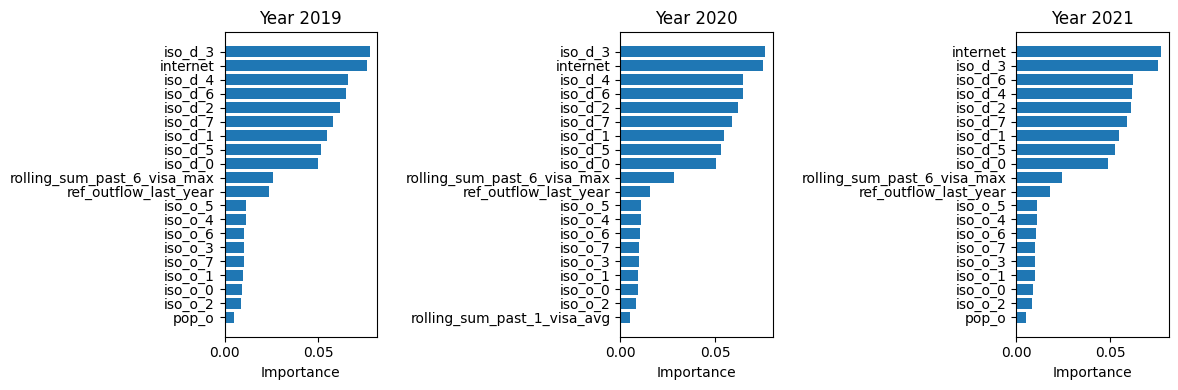

In [62]:
feature_years(feature_importances_dict)

With outflow predictions:

*********
Year: 2019
X_train uses data until: 2017
RMSE gtrends + ref_outflows_pred: 3739.4833319519857
*********
Year: 2020
X_train uses data until: 2018
RMSE gtrends + ref_outflows_pred: 1372.09733746699
*********
Year: 2021
X_train uses data until: 2019
RMSE gtrends + ref_outflows_pred: 1695.4559652609005
2645.1475057934913
1.0061005452762477


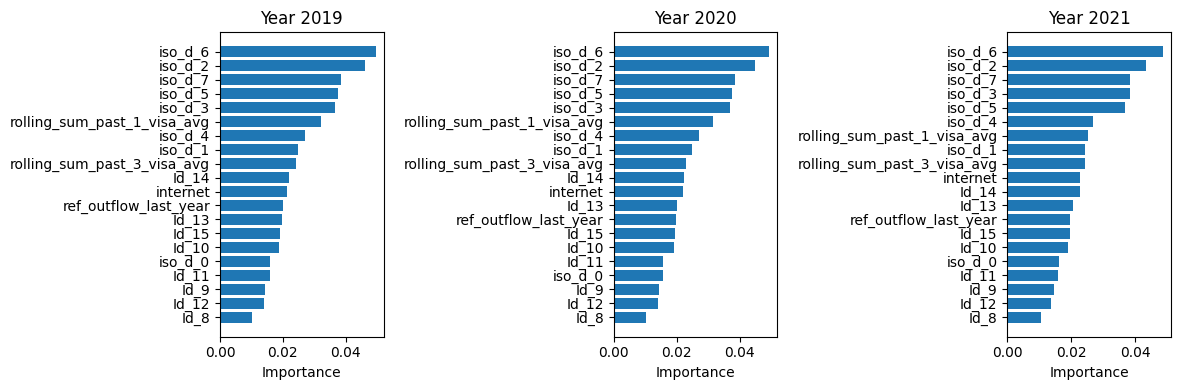

In [139]:
binary_cols = ['iso_o', 'iso_d', 'Id']

rf_pipe = model_helpers.pipeline_tree(model=RandomForestRegressor(random_state=SEED, n_jobs=-1), 
                                      df=trends_merged_t2,
                                      binary_cols=binary_cols)

X_train_list, X_test_list, y_train_list, y_test_list = model_helpers.train_test_split_rw(trends_merged_t2, 'target', test_time_start, test_time_end, 'year')

mse_moretrends_log_dict = {}
predictions_list = []
feature_importances_dict = {}
# Iterate over the test sets for each year
for year, X_train, X_test, y_train, y_test in zip(range(test_time_start, test_time_end + 1), X_train_list, X_test_list, y_train_list, y_test_list):


    # epsilon = 1e-8
    y_train_log = np.log(y_train + epsilon)

    rf_pipe.fit(X_train, y_train_log)

    # Predict on test set and transform back to original scale
    y_pred_log = rf_pipe.predict(X_test)
    y_pred = np.exp(y_pred_log) 


    # Get feature importances from the Random Forest model
    feature_importances = rf_pipe.named_steps['rf'].feature_importances_
    column_names = list(rf_pipe.named_steps['preprocessing'].transformers_[0][1].get_feature_names_out()) + numerical_cols
    # Store feature importances in the dictionary
    feature_importances_dict[year + 1] = dict(zip(column_names, feature_importances))

    
    mse_moretrends_log_year = mean_squared_error(y_test, y_pred, squared=False)

    mse_moretrends_log_dict[year + 1] = mse_moretrends_log_year

    print("*********")
    print("Year: " + str(year +1 ))
    print("X_train uses data until: " + str(X_train.year.max()))
    print("RMSE gtrends + ref_outflows_pred: " + str(mse_moretrends_log_year))

    # Store predicted values in DataFrame
    predictions_list.append(pd.DataFrame({"year": [year +1] * len(X_test),
                                            "iso_o": X_test["iso_o"].values,
                                            "y_pred_moretrends_log_rw": y_pred}))

    # Concatenate DataFrames from the list
    predictions_df_moretrends_log = pd.concat(predictions_list, ignore_index=True)

# recuperating y_test for the comparison
X_train, X_test, y_train, y_test = model_helpers.train_test_split(trends_merged_t1, 'target', test_time_start, test_time_end, 'year')

print(mean_squared_error(y_true=y_test, y_pred=predictions_df_moretrends_log.y_pred_moretrends_log_rw, squared=False))
print(mean_squared_error(y_true=y_test, y_pred=predictions_df_moretrends_log.y_pred_moretrends_log_rw, squared=False)/mse_naive)

feature_years(feature_importances_dict)

## Test: 1 model per dyad per year

Considering:
+ predicted outflow
+ last year newarrival
+ visa gtrend
+ cities + countries gtrend

In [79]:
reduc_trends_merged = trends_merged_t2.copy()
reduc_trends_merged["Id"] = reduc_trends_merged["iso_o"] + reduc_trends_merged["iso_d"]
reduc_trends_merged = reduc_trends_merged.drop(columns=["iso_o", "iso_d"])


In [80]:
# counts = reduc_trends_merged.Id.value_counts()

# reduc_trends_merged = pd.merge(reduc_trends_merged, counts, on=["Id"], how="left")

# reduc_trends_merged = reduc_trends_merged[reduc_trends_merged["count"]==16]

In [54]:
# grouped_data = reduc_trends_merged.groupby('Id')


Testing specific country model: AFGDEU

In [82]:
afgdeu = reduc_trends_merged[reduc_trends_merged["Id"]=="AFGDEU"]
afgdeu = afgdeu.drop(columns=["Id"])

In [85]:
afgdeu

,year,pop_o,visa_avg,visa_max,rolling_sum_past_1_visa_avg,rolling_sum_past_3_visa_avg,rolling_sum_past_6_visa_avg,rolling_sum_past_3_visa_max,rolling_sum_past_6_visa_max,internet,...,country_trend_mean,country_trend_max,city_trend,country_trend,rolling_sum_past_3_city_trend,rolling_sum_past_5_city_trend,rolling_sum_past_10_city_trend,rolling_sum_past_3_country_trend,rolling_sum_past_5_country_trend,rolling_sum_past_10_country_trend
1008,2005,20,0,0,0,0,0,0,0,1,...,787.074002,2564.222992,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
1009,2006,21,0,0,0,0,0,0,0,2,...,1137.636056,3185.380957,0.0,1592.690478,0.0,0.0,0.0,1592.690478,1592.690478,1592.690478
1010,2007,22,0,0,0,0,0,0,0,1,...,893.613806,1917.423000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
1011,2008,22,0,0,0,0,0,0,0,1,...,1081.370044,2115.724000,0.0,1622.055067,0.0,0.0,0.0,1622.055067,1622.055067,1622.055067
1012,2009,23,0,0,0,0,0,0,0,3,...,1896.364639,5584.386667,0.0,837.658000,0.0,0.0,0.0,837.658000,837.658000,837.658000
1013,2010,24,0,0,0,0,0,0,0,4,...,2656.107222,3397.660000,0.0,3235.866667,0.0,0.0,0.0,3235.866667,3235.866667,3235.866667
1014,2011,25,0,0,0,0,0,0,0,5,...,2798.604861,3754.650000,0.0,3754.650000,0.0,0.0,0.0,3754.650000,3754.650000,3754.650000
1015,2012,25,0,0,0,0,0,0,0,5,...,2586.400000,3056.654546,0.0,3056.654546,0.0,0.0,0.0,3056.654546,3056.654546,3056.654546
1016,2013,26,0,0,0,0,0,0,0,5,...,2913.852667,3680.656000,0.0,2366.136000,0.0,0.0,0.0,2366.136000,2366.136000,2366.136000
1017,2014,27,0,0,0,0,0,0,0,7,...,3864.140000,5796.210000,0.0,3864.140000,0.0,0.0,0.0,3864.140000,3864.140000,3864.140000


In [90]:

binary_cols = []

rf_pipe = model_helpers.pipeline_tree(model=RandomForestRegressor(random_state=SEED, n_jobs=-1), 
                                      df=afgdeu,
                                      binary_cols=binary_cols)

X_train_list, X_test_list, y_train_list, y_test_list = model_helpers.train_test_split_rw(afgdeu, 'target', 2014, test_time_end, 'year')

mse_afgdeu_dict = {}
predictions_list = []
# Iterate over the test sets for each year
for year, X_train, X_test, y_train, y_test in zip(range(2014, test_time_end + 1), X_train_list, X_test_list, y_train_list, y_test_list):



    rf_pipe.fit(X_train, y_train)

    # Predict on test set and transform back to original scale
    y_pred = rf_pipe.predict(X_test)

        
    mse_afgdeu_year = mean_squared_error(y_test, y_pred, squared=False)

    mse_afgdeu_dict[year + 1] = mse_afgdeu_year

    print("*********")
    print("Year: " + str(year +1 ))
    print("X_train uses data until: " + str(X_train.year.max()))
    print("RMSE gtrends + ref_outflows_pred: " + str(mse_afgdeu_year))
    # Store predicted values in DataFrame
    predictions_list.append(pd.DataFrame({"year": [year +1] * len(X_test),
                                            "y_pred_afgdeu_rw": y_pred,
                                            "y_test": y_test}))

    # Concatenate DataFrames from the list
    predictions_df_afgdeu = pd.concat(predictions_list, ignore_index=True)



*********
Year: 2015
X_train uses data until: 2013
RMSE gtrends + ref_outflows_pred: 23421.16
*********
Year: 2016
X_train uses data until: 2014
RMSE gtrends + ref_outflows_pred: 109299.11
*********
Year: 2017
X_train uses data until: 2015
RMSE gtrends + ref_outflows_pred: 78310.44
*********
Year: 2018
X_train uses data until: 2016
RMSE gtrends + ref_outflows_pred: 38583.69
*********
Year: 2019
X_train uses data until: 2017
RMSE gtrends + ref_outflows_pred: 14239.91
*********
Year: 2020
X_train uses data until: 2018
RMSE gtrends + ref_outflows_pred: 6507.8499999999985
*********
Year: 2021
X_train uses data until: 2019
RMSE gtrends + ref_outflows_pred: 9155.43


In [91]:
predictions_df_afgdeu

,year,y_pred_afgdeu_rw,y_test
0,2015,7960.84,31382.0
1,2016,17712.89,127012.0
2,2017,94733.44,16423.0
3,2018,48525.69,9942.0
4,2019,23761.91,9522.0
5,2020,16408.85,9901.0
6,2021,14120.57,23276.0


In [95]:
predictions_df_afgdeu["y_naive"] = predictions_df_afgdeu["y_test"].shift(1)
predictions_df_afgdeu= predictions_df_afgdeu.dropna()

In [96]:
print(mean_squared_error(y_true=predictions_df_afgdeu.y_test, y_pred=predictions_df_afgdeu.y_pred_afgdeu_rw, squared=False))
mse_naive_afgdeu  = mean_squared_error(y_true=predictions_df_afgdeu.y_test, y_pred=predictions_df_afgdeu.y_naive, squared=False)
print(mean_squared_error(y_true=predictions_df_afgdeu.y_test, y_pred=predictions_df_afgdeu.y_pred_afgdeu_rw, squared=False)/mse_naive_afgdeu)



57585.40127601397
0.9598402810420116


In [55]:
from tqdm.notebook import tqdm

binary_cols = ['Id']

mse_dyad_log_dict = {}
predictions_df_list = []  # List to store predictions DataFrames for each dyad

for id_group, group_data in tqdm(grouped_data):
    
    rf_pipe = model_helpers.pipeline_tree(model=RandomForestRegressor(random_state=SEED, n_jobs=-1), 
                                          df=group_data,
                                          binary_cols=binary_cols)

    X_train, X_test, y_train, y_test = model_helpers.train_test_split(group_data, 'target', test_time_start, test_time_end, 'year')
    identifier = str(id_group)  # Create the identifier for the dyad

    epsilon = 1e-8
    y_train_log = np.log(y_train + epsilon)

    rf_pipe.fit(X_train, y_train_log)

    # Predict on test set and transform back to the original scale
    y_pred_log = rf_pipe.predict(X_test)
    y_pred = np.exp(y_pred_log)

    mse_dyad_log_year = mean_squared_error(y_test, y_pred, squared=False)

    mse_dyad_log_dict[identifier] = mse_dyad_log_year

    # Store predicted values in DataFrame with group and year columns
    predictions_df = pd.DataFrame({"group": [id_group] * len(X_test),
                                   "year": [test_time_end + 1] * len(X_test),
                                   "y_pred_dyad_log_rw": y_pred})

    predictions_df_list.append(predictions_df)

# Concatenate DataFrames from the list
predictions_df_dyad_log = pd.concat(predictions_df_list, ignore_index=True)


  0%|          | 0/38218 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [58]:
from tqdm.notebook import trange, tqdm

test_time_start = 2020
test_time_end = 2020
binary_cols = ['Id']

mse_dyad_log_dict = {}
predictions_df_list = []  # List to store predictions DataFrames for each dyad

for id_group, group_data in tqdm(grouped_data):
    
    rf_pipe = model_helpers.pipeline_tree(model=RandomForestRegressor(random_state=SEED, n_jobs=-1), 
                                          df=group_data,
                                          binary_cols=binary_cols)

    X_train_list, X_test_list, y_train_list, y_test_list = model_helpers.train_test_split_rw(group_data, 'target', test_time_start, test_time_end, 'year')

    # Iterate over the test sets for each year
    for year, X_train, X_test, y_train, y_test in zip(range(test_time_start, test_time_end + 1), X_train_list, X_test_list, y_train_list, y_test_list):
        identifier = str(id_group) + "+" + str(year + 1)
        # epsilon = 1e-8
        y_train_log = np.log(y_train + epsilon)

        rf_pipe.fit(X_train, y_train_log)

        # Predict on test set and transform back to the original scale
        y_pred_log = rf_pipe.predict(X_test)
        y_pred = np.exp(y_pred_log)

        mse_dyad_log_year = mean_squared_error(y_test, y_pred, squared=False)

        mse_dyad_log_dict[identifier] = mse_dyad_log_year

        # Store predicted values in DataFrame with group and year columns
        predictions_df = pd.DataFrame({"group": [id_group] * len(X_test),
                                       "year": [year + 1] * len(X_test),
                                       "y_pred_dyad_log_rw": y_pred})

        predictions_df_list.append(predictions_df)

# Concatenate DataFrames from the list
predictions_df_dyad_log = pd.concat(predictions_df_list, ignore_index=True)



  0%|          | 0/38218 [00:00<?, ?it/s]

ValueError: Found array with 0 sample(s) (shape=(0, 24)) while a minimum of 1 is required by RobustScaler.

In [ ]:
# recuperating y_test for the comparison
X_train, X_test, y_train, y_test = model_helpers.train_test_split(trends_merged_t1, 'target', test_time_start, test_time_end, 'year')

print(mean_squared_error(y_true=y_test, y_pred=predictions_df_moretrends_log.y_pred_moretrends_log_rw, squared=False))
print(mean_squared_error(y_true=y_test, y_pred=predictions_df_moretrends_log.y_pred_moretrends_log_rw, squared=False)/mse_naive)



### Modeling by origin country? Ratios?

Generating ratios

In [97]:
reduc_trends_merged.columns

Index(['year', 'pop_o', 'visa_avg', 'visa_max', 'rolling_sum_past_1_visa_avg',
       'rolling_sum_past_3_visa_avg', 'rolling_sum_past_6_visa_avg',
       'rolling_sum_past_3_visa_max', 'rolling_sum_past_6_visa_max',
       'internet', 'target', 'ref_outflow_last_year', 'ref_outflow_pred',
       'city_trend_mean', 'city_trend_max', 'country_trend_mean',
       'country_trend_max', 'city_trend', 'country_trend',
       'rolling_sum_past_3_city_trend', 'rolling_sum_past_5_city_trend',
       'rolling_sum_past_10_city_trend', 'rolling_sum_past_3_country_trend',
       'rolling_sum_past_5_country_trend', 'rolling_sum_past_10_country_trend',
       'Id'],
      dtype='object')

In [98]:
df_ratios = reduc_trends_merged.copy()

df_ratios['ratio'] = df_ratios['target'] / df_ratios['ref_outflow_pred']
df_ratios['ratio'] = df_ratios['ratio'].fillna(0)
df_ratios = df_ratios.drop(columns=["target"])



In [99]:
df_ratios.replace([np.inf, -np.inf], 0, inplace=True)


In [100]:
df_ratios

,year,pop_o,visa_avg,visa_max,rolling_sum_past_1_visa_avg,rolling_sum_past_3_visa_avg,rolling_sum_past_6_visa_avg,rolling_sum_past_3_visa_max,rolling_sum_past_6_visa_max,internet,...,city_trend,country_trend,rolling_sum_past_3_city_trend,rolling_sum_past_5_city_trend,rolling_sum_past_10_city_trend,rolling_sum_past_3_country_trend,rolling_sum_past_5_country_trend,rolling_sum_past_10_country_trend,Id,ratio
0,2005,20,0,0,0,0,0,0,0,1,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,AFGALB,0.000000
1,2006,21,0,0,0,0,0,0,0,2,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,AFGALB,0.000000
2,2007,22,0,0,0,0,0,0,0,1,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,AFGALB,0.000000
3,2008,22,0,0,0,0,0,0,0,1,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,AFGALB,0.000000
4,2009,23,0,0,0,0,0,0,0,3,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,AFGALB,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
611478,2016,14,644,644,644,644,644,644,644,23,...,1333.118038,8881.682510,1333.118038,1333.118038,1333.118038,8881.682510,8881.682510,8881.682510,ZWEZMB,0.000000
611479,2017,14,336,336,336,336,336,336,336,24,...,1585.182600,8806.570000,1585.182600,1585.182600,1585.182600,8806.570000,8806.570000,8806.570000,ZWEZMB,0.000442
611480,2018,14,0,0,0,0,0,0,0,25,...,915.125000,7687.050000,915.125000,915.125000,915.125000,7687.050000,7687.050000,7687.050000,ZWEZMB,0.000000
611481,2019,14,364,364,364,364,364,364,364,26,...,792.596450,7529.666275,792.596450,792.596450,792.596450,7529.666275,7529.666275,7529.666275,ZWEZMB,0.000475


In [101]:
from tqdm.notebook import tqdm

binary_cols = ['Id', 'iso_d', 'iso_o']

mse_dyad_log_dict = {}
predictions_df_list = []  # List to store predictions DataFrames for each dyad

for iso_o in tqdm(df_ratios["iso_o"]):
    

    rf_pipe = model_helpers.pipeline_tree(model=RandomForestRegressor(random_state=SEED, n_jobs=-1), 
                                          df=df_ratios,
                                          binary_cols=binary_cols)
    group = df_ratios[df_ratios["iso_o"]==iso_o]
    X_train, X_test, y_train, y_test = model_helpers.train_test_split(group, 'ratio', test_time_start, test_time_end, 'year')
    
    
    rf_pipe.fit(X_train, y_train)

    # Predict on test set and transform back to the original scale
    y_pred = rf_pipe.predict(X_test)

    mse_dyad_log_year = mean_squared_error(y_test, y_pred, squared=False)

    mse_dyad_log_dict[iso_o] = mse_dyad_log_year

    # Store predicted values in DataFrame with group and year columns
    predictions_df = pd.DataFrame({"group": [iso_o] * len(X_test),
                                   "year": [test_time_end + 1] * len(X_test),
                                   "y_pred_dyad_log_rw": y_pred})

    predictions_df_list.append(predictions_df)

# Concatenate DataFrames from the list
predictions_df_dyad_log = pd.concat(predictions_df_list, ignore_index=True)



KeyError: 'iso_o'

## Model 4: full model (including UNHCR covs and historical features)

Finally, adding historical data + dyad data from UNHCR

In [140]:
unhcr_covs = dyad_covs.drop(columns=trends_cols)

In [141]:
df_merged_unhcr = pd.merge(trends_merged_t2, unhcr_covs, on=["year", "iso_o", "iso_d"], how="left")


In [142]:
unhcr_orig = pd.read_csv(path + "unhcr.csv")

In [143]:
unhcr_orig = unhcr_orig[["iso_o", "iso_d", "year", "newarrival"]]
unhcr_orig["year"] = pd.to_datetime(unhcr_orig["year"], format="%Y")
unhcr_orig["year"] = unhcr_orig["year"].dt.year
unhcr_orig

,iso_o,iso_d,year,newarrival
0,AFG,ALB,2000,4.0
1,AFG,ALB,2001,0.0
2,AFG,ALB,2002,0.0
3,AFG,ALB,2003,0.0
4,AFG,ALB,2004,0.0
...,...,...,...,...
955495,ZWE,ZMB,2020,1.0
955496,ZWE,ZMB,2021,0.0
955497,ZWE,ZMB,2022,NaN
955498,ZWE,ZMB,2023,NaN


In [144]:
df_merged_unhcr = pd.merge(df_merged_unhcr, unhcr_orig, on=["iso_o", "iso_d", "year"], how="left")

In [145]:
df_merged_unhcr = df_merged_unhcr.drop(columns=["Id_x"])
df_merged_unhcr = df_merged_unhcr.rename(columns={"Id_y":"Id"})

In [146]:
df_merged_unhcr.year.value_counts()

year
2005    38218
2006    38218
2007    38218
2008    38218
2009    38218
2010    38218
2011    38218
2012    38218
2013    38218
2014    38218
2015    38218
2016    38218
2017    38217
2019    38217
2020    38217
2018    38216
Name: count, dtype: int64

Let's first try Random Forest:

In [147]:
be = BinaryEncoder() # doing be on everything yields better results
cont_scaler = RobustScaler()

# binary_cols = ['iso_o']
# ohe_cols = ['iso_o_continent','typeOfViolence_o']
binary_cols = ['iso_o', 'iso_d',  'Id', 'iso_d_continent', 'typeOfViolence_d']

# numerical_cols = list(set(unhcr.columns) - set(binary_cols + ohe_cols + ['year', 'ref_outflow']))
numerical_cols = list(set(df_merged_unhcr.columns) - set(binary_cols  + ['year', 'target']))

transform_cols = ColumnTransformer(
    [
        ('cat1', be, binary_cols),
   #     ('cat2', ohe, ohe_cols),
        ('num', cont_scaler, numerical_cols)
    ],
    remainder='passthrough'
)

gb_pipe = Pipeline([('preprocessing', transform_cols),
                    ('gb', RandomForestRegressor(random_state=SEED))])

In [148]:
df_merged_unhcr = df_merged_unhcr.dropna()

In [149]:
X_train_list, X_test_list, y_train_list, y_test_list = model_helpers.train_test_split_rw(df_merged_unhcr, 'target', test_time_start, test_time_end, 'year')

In [150]:
mse_fullcovs_log_dict = {}
predictions_list = []
feature_importances_dict = {}
# Iterate over the test sets for each year
for year, X_train, X_test, y_train, y_test in zip(range(test_time_start, test_time_end + 1), X_train_list, X_test_list, y_train_list, y_test_list):


    epsilon = 1e-8
    y_train_log = np.log(y_train + epsilon)

    gb_pipe.fit(X_train, y_train_log)

    # Predict on test set and transform back to original scale
    y_pred_log = gb_pipe.predict(X_test)
    y_pred = np.exp(y_pred_log) 

    # Get feature importances from the Random Forest model
    feature_importances = gb_pipe.named_steps['gb'].feature_importances_
    column_names = list(gb_pipe.named_steps['preprocessing'].transformers_[0][1].get_feature_names_out()) + numerical_cols
    # Store feature importances in the dictionary
    feature_importances_dict[year+1] = dict(zip(column_names, feature_importances))

    
    mse_fullcovs_log_year = mean_squared_error(y_test, y_pred, squared=False)

    mse_fullcovs_log_dict[year+1] = mse_fullcovs_log_year

    print("*********")
    print("Year: " + str(year+1))
    print("X_train uses data until: " + str(X_train.year.max()))
    print("RMSE gtrends (visa) + ref_outflows_pred: " + str(mse_fullcovs_log_year))

    # Store predicted values in DataFrame
    predictions_list.append(pd.DataFrame({"year": [year+1] * len(X_test),
                                            "iso_o": X_test["iso_o"].values,
                                            "y_pred_fullcovs_log_rw": y_pred}))

    # Concatenate DataFrames from the list
    predictions_df_fullcovs_log = pd.concat(predictions_list, ignore_index=True)

KeyboardInterrupt: 

In [ ]:
# recuperating y_test for the comparison
X_train, X_test, y_train, y_test = model_helpers.train_test_split(df_merged_unhcr, 'target', test_time_start, test_time_end, 'year')

print(mean_squared_error(y_true=y_test, y_pred=predictions_df_fullcovs_log.y_pred_fullcovs_log_rw, squared=False))
print(mean_squared_error(y_true=y_test, y_pred=predictions_df_fullcovs_log.y_pred_fullcovs_log_rw, squared=False)/mse_naive)

4828.890207549459
1.0315356708644616


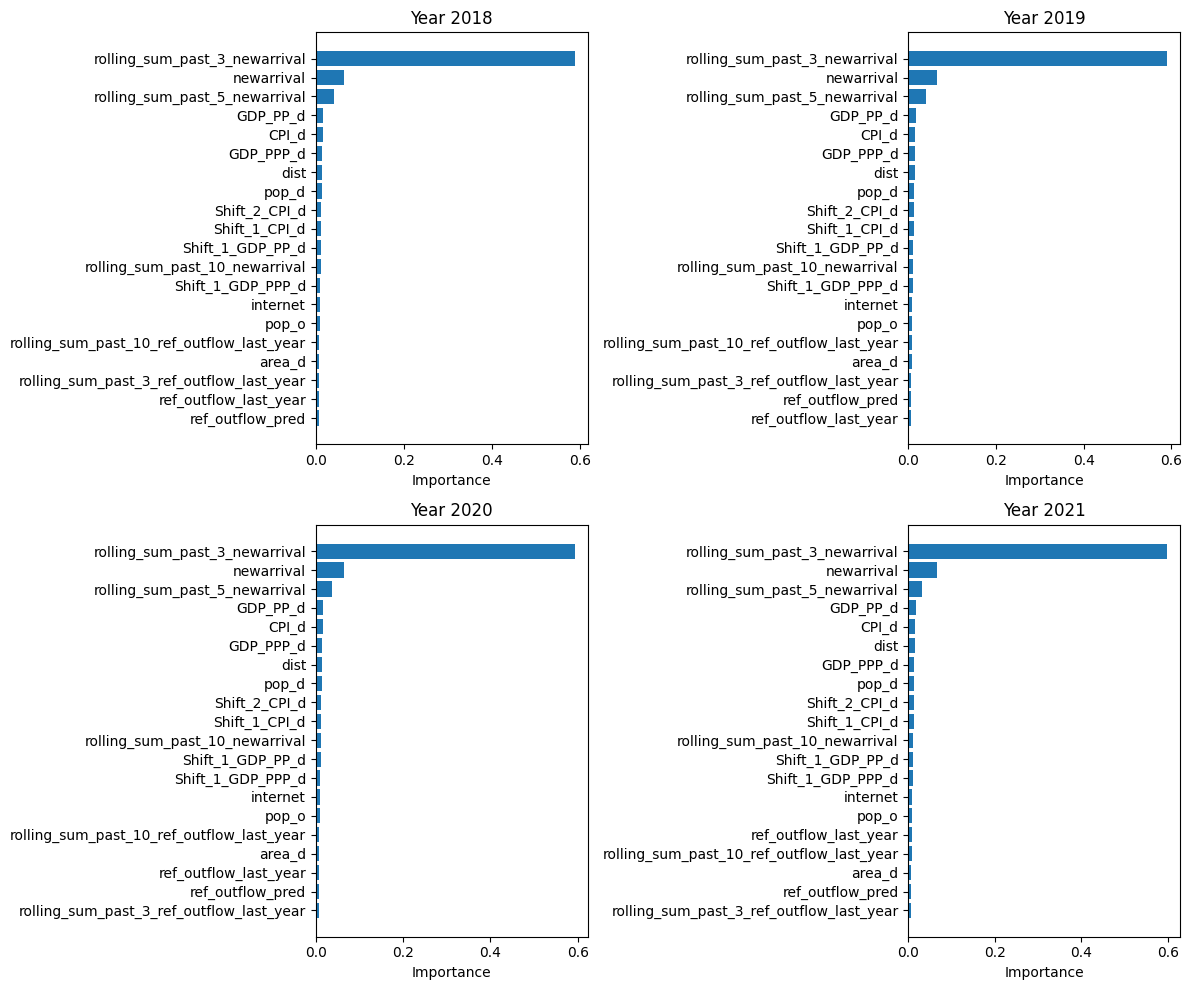

In [ ]:
feature_years(feature_importances_dict)

Now **Gradient Boosting**:

In [151]:
be = BinaryEncoder() # doing be on everything yields better results
cont_scaler = RobustScaler()

# binary_cols = ['iso_o']
# ohe_cols = ['iso_o_continent','typeOfViolence_o']
binary_cols = ['iso_o', 'iso_d',  'Id', 'iso_d_continent', 'typeOfViolence_d']

# numerical_cols = list(set(unhcr.columns) - set(binary_cols + ohe_cols + ['year', 'ref_outflow']))
numerical_cols = list(set(df_merged_unhcr.columns) - set(binary_cols  + ['year', 'target']))

transform_cols = ColumnTransformer(
    [
        ('cat1', be, binary_cols),
   #     ('cat2', ohe, ohe_cols),
        ('num', cont_scaler, numerical_cols)
    ],
    remainder='passthrough'
)

gb_pipe = Pipeline([('preprocessing', transform_cols),
                    ('gb', GradientBoostingRegressor(random_state=SEED))])

In [152]:
X_train, X_test, y_train, y_test = model_helpers.train_test_split(df_merged_unhcr, 'target', test_time_start, test_time_end, 'year')

# Add a small constant to handle zero values
epsilon = 1e-8
y_train_log = np.log(y_train + epsilon)

gb_pipe.fit(X_train, y_train_log)

# Predict on test set and transform back to original scale
y_pred_log = gb_pipe.predict(X_test)
y_pred = np.exp(y_pred_log) 

mse_fullcovs_log = mean_squared_error(y_test, y_pred, squared=False)


In [153]:
print("RMSE full covs: " + str(mse_fullcovs_log))
print("Relative RMSE to Naive predictions: " + str(mse_fullcovs_log / mse_naive))

RMSE full covs: 2565.0753049654854
Relative RMSE to Naive predictions: 0.9756445178758555


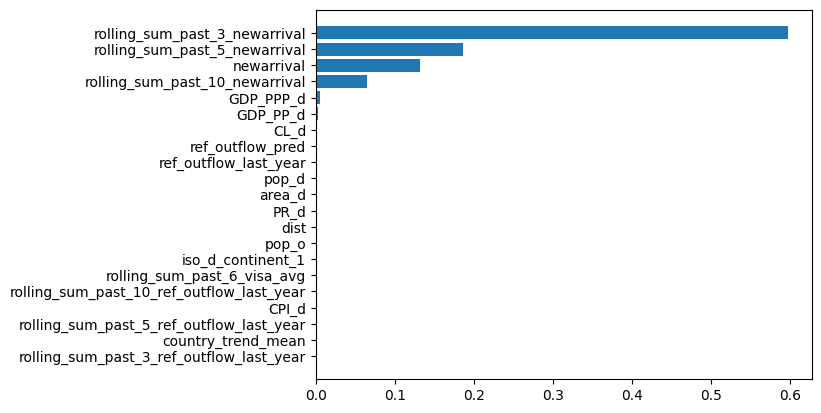

In [154]:
importances = gb_pipe.named_steps['gb'].feature_importances_

# Get column names from ColumnTransformer object
column_names = list(gb_pipe.named_steps['preprocessing'].transformers_[0][1].get_feature_names_out()) + numerical_cols


# Map feature importances to column names
feature_importances = dict(zip(column_names, importances))

indexes = model_helpers.feature_imp_more(feature_importances)

In [155]:
X_train_list, X_test_list, y_train_list, y_test_list = model_helpers.train_test_split_rw(df_merged_unhcr, 'target', test_time_start, test_time_end, 'year')

In [156]:
mse_fullcovs_gb_log_dict = {}
predictions_list = []
feature_importances_dict = {}
# Iterate over the test sets for each year
for year, X_train, X_test, y_train, y_test in zip(range(test_time_start, test_time_end + 1), X_train_list, X_test_list, y_train_list, y_test_list):


    epsilon = 1e-8
    y_train_log = np.log(y_train + epsilon)

    gb_pipe.fit(X_train, y_train_log)

    # Predict on test set and transform back to original scale
    y_pred_log = gb_pipe.predict(X_test)
    y_pred = np.exp(y_pred_log) 

    # Get feature importances from the Random Forest model
    feature_importances = gb_pipe.named_steps['gb'].feature_importances_
    column_names = list(gb_pipe.named_steps['preprocessing'].transformers_[0][1].get_feature_names_out()) + numerical_cols
    # Store feature importances in the dictionary
    feature_importances_dict[year] = dict(zip(column_names, feature_importances))

    
    mse_fullcovs_gb_log_year = mean_squared_error(y_test, y_pred, squared=False)

    mse_fullcovs_gb_log_dict[year] = mse_fullcovs_gb_log_year

    print("*********")
    print("Year: " + str(year))
    print("X_train uses data until: " + str(X_train.year.max()))
    print("RMSE gtrends (visa) + ref_outflows_pred: " + str(mse_fullcovs_gb_log_year))
    print("Relative RMSE to Naive predictions: " + str(mse_fullcovs_gb_log_year / mse_naive_dict[year+1]))


    # Store predicted values in DataFrame
    predictions_list.append(pd.DataFrame({"year": [year] * len(X_test),
                                            "iso_o": X_test["iso_o"].values,
                                            "y_pred_fullcovs_gb_log_rw": y_pred}))

    # Concatenate DataFrames from the list
    predictions_df_fullcovs_gb_log = pd.concat(predictions_list, ignore_index=True)

*********
Year: 2018
X_train uses data until: 2017
RMSE gtrends (visa) + ref_outflows_pred: 3826.044880272895
Relative RMSE to Naive predictions: 1.2021015090442535
*********
Year: 2019
X_train uses data until: 2018
RMSE gtrends (visa) + ref_outflows_pred: 1302.1986312690244
Relative RMSE to Naive predictions: 0.4316500952516897
*********
Year: 2020
X_train uses data until: 2019
RMSE gtrends (visa) + ref_outflows_pred: 1902.9805069222816
Relative RMSE to Naive predictions: 1.5509857859289669


In [157]:
# recuperating y_test for the comparison
X_train, X_test, y_train, y_test = model_helpers.train_test_split(df_merged_unhcr, 'target', test_time_start, test_time_end, 'year')

print(mean_squared_error(y_true=y_test, y_pred=predictions_df_fullcovs_gb_log.y_pred_fullcovs_gb_log_rw, squared=False))
print(mean_squared_error(y_true=y_test, y_pred=predictions_df_fullcovs_gb_log.y_pred_fullcovs_gb_log_rw, squared=False)/mse_naive)

2713.254318102339
1.0320054526021638


KeyError: 2021

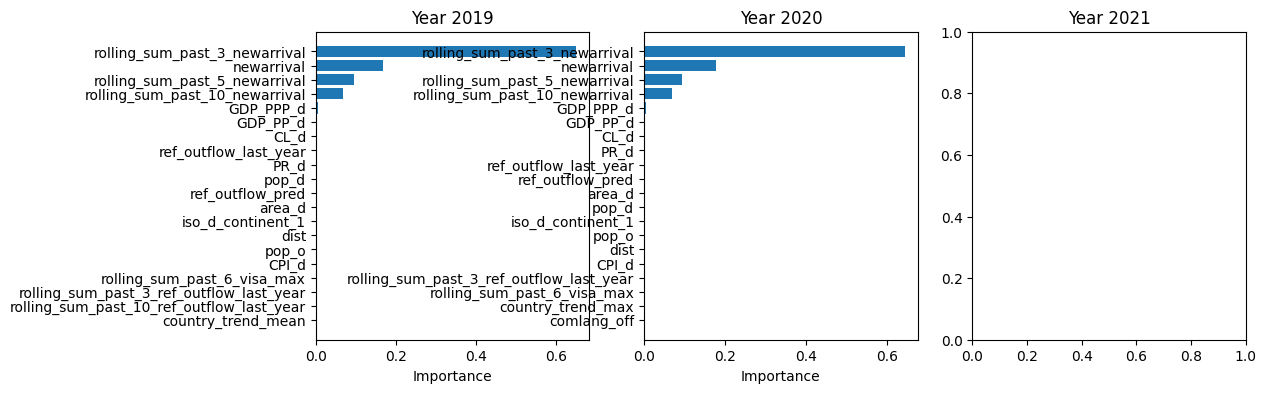

In [158]:
feature_years(feature_importances_dict)

## Model 5: full model + undersampling 0s

GB full - undersampling 0s

In [ ]:
X_train_list, X_test_list, y_train_list, y_test_list = model_helpers.train_test_split_rw(df_merged_unhcr, 'target', test_time_start, test_time_end, 'year')

In [ ]:
binary_cols = ['iso_o', 'iso_d',  'Id', 'iso_d_continent', 'typeOfViolence_d']

gb_pipe = model_helpers.pipeline_tree(model=RandomForestRegressor(random_state=SEED, n_jobs=-1),
                                      df=df_merged_unhcr,
                                      binary_cols=binary_cols)

In [ ]:
mse_fullcovs_unders_log_dict = {}
predictions_list = []
feature_importances_dict = {}

# Iterate over the test sets for each year

for year, X_train, X_test, y_train, y_test in zip(range(test_time_start, test_time_end + 1), X_train_list, X_test_list, y_train_list, y_test_list):

    zeros_sample_index = y_train[y_train == 0].sample(frac=.20, random_state=42).index
    X_train_undersampled = X_train[(y_train != 0) | (y_train.index.isin(zeros_sample_index))]
    y_train_undersampled = y_train[(y_train != 0) | (y_train.index.isin(zeros_sample_index))]

    epsilon = 1e-8
    y_train_log = np.log(y_train_undersampled + epsilon)

    gb_pipe.fit(X_train_undersampled, y_train_log)

    # Predict on test set and transform back to original scale
    y_pred_log = gb_pipe.predict(X_test)
    y_pred = np.exp(y_pred_log) 

    # Get feature importances from the Random Forest model
    feature_importances = gb_pipe.named_steps['rf'].feature_importances_
    column_names = list(gb_pipe.named_steps['preprocessing'].transformers_[0][1].get_feature_names_out()) + numerical_cols
    # Store feature importances in the dictionary
    feature_importances_dict[year+1] = dict(zip(column_names, feature_importances))

    
    mse_fullcovs_unders_log_year = mean_squared_error(y_test, y_pred, squared=False)

    mse_fullcovs_unders_log_dict[year+1] = mse_fullcovs_unders_log_year

    print("*********")
    print("Year: " + str(year+1))
    print("X_train uses data until: " + str(X_train.year.max()))
    print("RMSE full model (0 undersample): " + str(mse_fullcovs_unders_log_year))
    print("Relative RMSE to Naive predictions: " + str(mse_fullcovs_unders_log_year / mse_naive_dict[year+1]))

    # Store predicted values in DataFrame
    predictions_list.append(pd.DataFrame({"year": [year+1] * len(X_test),
                                            "iso_o": X_test["iso_o"].values,
                                            "y_pred_fullcovs_unders_log_rw": y_pred}))

    # Concatenate DataFrames from the list
    predictions_df_fullcovs_unders_log = pd.concat(predictions_list, ignore_index=True)

*********
Year: 2018
X_train uses data until: 2016
RMSE full model (0 undersample): 7275.881790828986
*********
Year: 2019
X_train uses data until: 2017
RMSE full model (0 undersample): 3655.0154248705553
*********
Year: 2020
X_train uses data until: 2018
RMSE full model (0 undersample): 1535.0458066492317
*********
Year: 2021
X_train uses data until: 2019
RMSE full model (0 undersample): 1523.9971628869134


In [ ]:
# recuperating y_test for the comparison
X_train, X_test, y_train, y_test = model_helpers.train_test_split(df_merged_unhcr, 'target', test_time_start, test_time_end, 'year')

print(mean_squared_error(y_true=y_test, y_pred=predictions_df_fullcovs_unders_log.y_pred_fullcovs_unders_log_rw, squared=False))
print(mean_squared_error(y_true=y_test, y_pred=predictions_df_fullcovs_unders_log.y_pred_fullcovs_unders_log_rw, squared=False)/mse_naive)

4895.114297791501
1.045682298437069


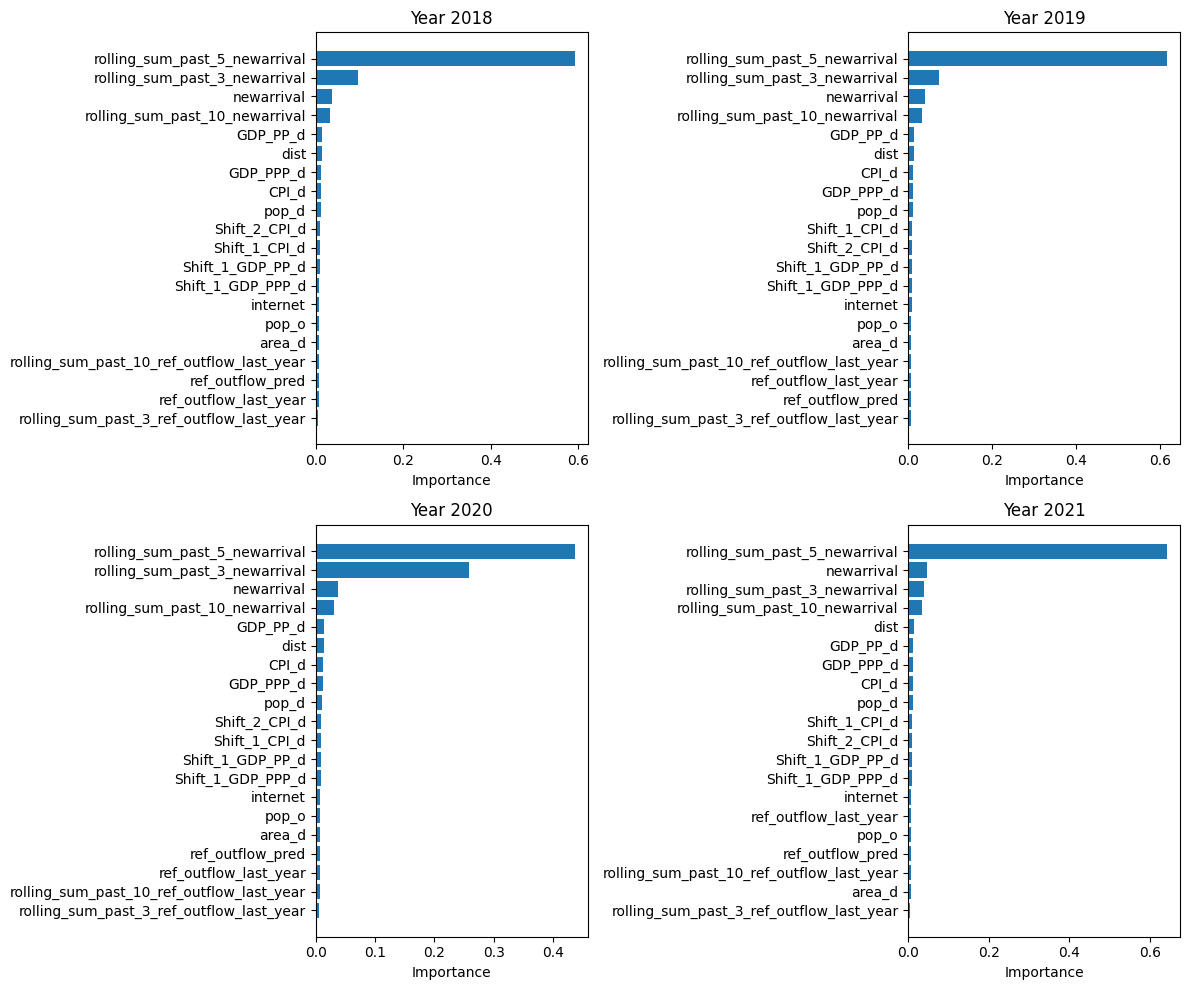

In [ ]:
feature_years(feature_importances_dict)

## Model 6: how does the model looks without GTrends?

This implementation takes exclusively UNHCR covariates and historical features. But it does use our refugee outflow predictions.

In [ ]:
unhcr_covs_2 = pd.merge(trends_merged_t2[["year", "iso_o", "iso_d", "target", "ref_outflow_pred_test"]], unhcr_covs, on=["year", "iso_o", "iso_d"], how="left")

In [ ]:
be = BinaryEncoder() # doing be on everything yields better results
cont_scaler = RobustScaler()

# binary_cols = ['iso_o']
# ohe_cols = ['iso_o_continent','typeOfViolence_o']
binary_cols = ['iso_o', 'iso_d',  'Id', 'iso_d_continent', 'typeOfViolence_d']

# numerical_cols = list(set(unhcr.columns) - set(binary_cols + ohe_cols + ['year', 'ref_outflow']))
numerical_cols = list(set(unhcr_covs_2.columns) - set(binary_cols  + ['year', 'target']))

transform_cols = ColumnTransformer(
    [
        ('cat1', be, binary_cols),
   #     ('cat2', ohe, ohe_cols),
        ('num', cont_scaler, numerical_cols)
    ],
    remainder='passthrough'
)

gb_pipe = Pipeline([('preprocessing', transform_cols),
                    ('gb', GradientBoostingRegressor(random_state=SEED))])

In [ ]:
X_train_list, X_test_list, y_train_list, y_test_list = model_helpers.train_test_split_rw(unhcr_covs_2, 'target', test_time_start, test_time_end, 'year')

In [ ]:

mse_onlyunhcr_gb_log_dict = {}
predictions_list = []
feature_importances_dict = {}
# Iterate over the test sets for each year
for year, X_train, X_test, y_train, y_test in zip(range(test_time_start, test_time_end + 1), X_train_list, X_test_list, y_train_list, y_test_list):


    epsilon = 1e-8
    y_train_log = np.log(y_train + epsilon)

    gb_pipe.fit(X_train, y_train_log)

    # Predict on test set and transform back to original scale
    y_pred_log = gb_pipe.predict(X_test)
    y_pred = np.exp(y_pred_log) 

    # Get feature importances from the Random Forest model
    feature_importances = gb_pipe.named_steps['gb'].feature_importances_
    column_names = list(gb_pipe.named_steps['preprocessing'].transformers_[0][1].get_feature_names_out()) + numerical_cols
    # Store feature importances in the dictionary
    feature_importances_dict[year] = dict(zip(column_names, feature_importances))

    
    mse_onlyunhcr_gb_log_year = mean_squared_error(y_test, y_pred, squared=False)

    mse_onlyunhcr_gb_log_dict[year] = mse_onlyunhcr_gb_log_year

    print("*********")
    print("Year: " + str(year))
    print("X_train uses data until: " + str(X_train.year.max()))
    print("RMSE gtrends - only UNHCR + ref_outflows pred: " + str(mse_onlyunhcr_gb_log_year))
    print("Relative RMSE to Naive predictions: " + str(mse_fullcovs_unders_log_year / mse_naive_dict[year+1]))

    # Store predicted values in DataFrame
    predictions_list.append(pd.DataFrame({"year": [year] * len(X_test),
                                            "iso_o": X_test["iso_o"].values,
                                            "y_pred_onlyunhcr_gb_log_rw": y_pred}))

    # Concatenate DataFrames from the list
    predictions_df_onlyunhcr_gb_log = pd.concat(predictions_list, ignore_index=True)


*********
Year: 2018
X_train uses data until: 2017
RMSE gtrends - only UNHCR + ref_outflows pred: 3072.4177621483936
*********
Year: 2019
X_train uses data until: 2018
RMSE gtrends - only UNHCR + ref_outflows pred: 1199.757749494656
*********
Year: 2020
X_train uses data until: 2019
RMSE gtrends - only UNHCR + ref_outflows pred: 1736.60013818161
*********
Year: 2021
X_train uses data until: 2020
RMSE gtrends - only UNHCR + ref_outflows pred: 84.84458273686074


In [ ]:

# recuperating y_test for the comparison
X_train, X_test, y_train, y_test = model_helpers.train_test_split(unhcr_covs_2, 'target', test_time_start, test_time_end, 'year')

print(mean_squared_error(y_true=y_test, y_pred=predictions_df_onlyunhcr_gb_log.y_pred_onlyunhcr_gb_log_rw, squared=False))
print(mean_squared_error(y_true=y_test, y_pred=predictions_df_onlyunhcr_gb_log.y_pred_onlyunhcr_gb_log_rw, squared=False)/mse_naive)


1995.3749336827025
0.4262470945445358


The results by themselves are pretty good. With gtrends + undersampling they improve, but ever so slightly. 

However, a main takeaway is what we can do without certainty of historical features at the dyad level.

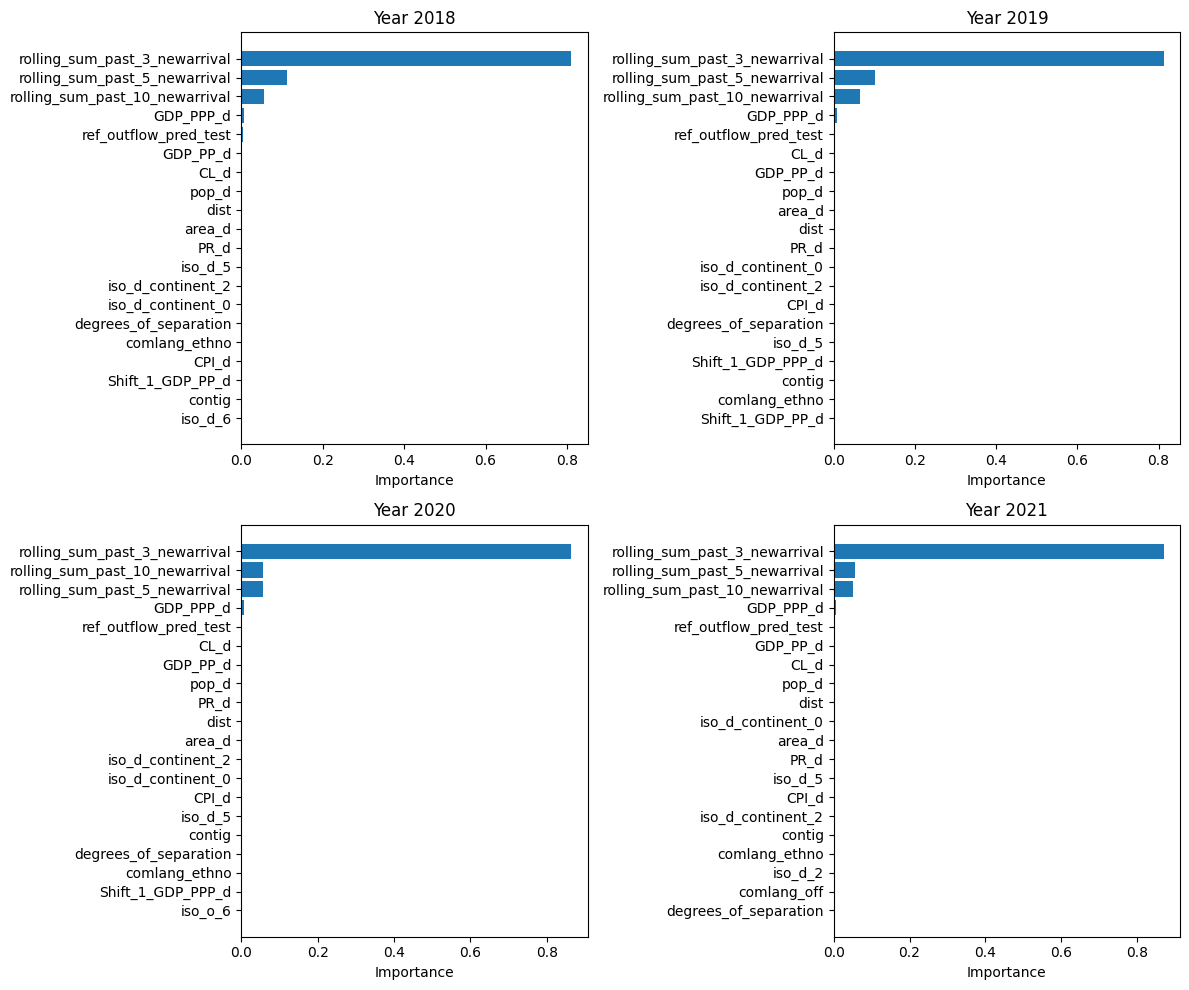

In [224]:

# List of years
years = [2018, 2019, 2020, 2021]

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Flatten the axes to iterate over them easily
axes = axes.flatten()

# Iterate over the years and plot the bar plots in the grid
for i, year in enumerate(years):
    ax = axes[i]
    ax.set_title(f"Year {year}")  # Set title for each subplot with the corresponding year
    
    
    # Sort the feature importances in descending order and get the top 20 features
    top_features = sorted(feature_importances_dict[year].items(), key=lambda x: x[1], reverse=True)[:20]
    top_features = list(reversed(top_features))
    top_features_names, top_features_importances = zip(*top_features)
    
    # Plot the bar chart
    ax.barh(range(len(top_features_names)), top_features_importances, align='center')
    ax.set_yticks(range(len(top_features_names)))
    ax.set_yticklabels(top_features_names)
    ax.set_xlabel('Importance')

# Adjust the layout and spacing
plt.tight_layout()

# Show the plots
plt.show()